In [3]:
import numpy as np
import pandas as pd


from PIL import Image
from io import BytesIO
from urllib import request

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
img_size = 128

start_path = '/kaggle/working/dice'
train_path = f"{start_path}/train/"
val_path = f"{start_path}/valid/"

def download_image(url):
    
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

def preprocess(X, rescale=255):
    
    if rescale:
        X = X*1./rescale
        return X
    return X
    

train_gen = ImageDataGenerator(preprocessing_function=preprocess, #rescale=1./255)
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_dataset = train_gen.flow_from_directory(directory=train_path,
                                              target_size=(img_size, img_size),
#                                               classes=['dicesback'],
                                              class_mode='categorical',
                                              shuffle=True,
                                              batch_size=64)

valid_gen = ImageDataGenerator(preprocessing_function=preprocess) #rescale=1./255)
valid_dataset = valid_gen.flow_from_directory(directory=val_path,
                                              target_size=(img_size, img_size),
#                                               classes=['dicesback'],
                                              class_mode='categorical',
                                              shuffle=True,
                                              batch_size=64)

classes = list(train_dataset.class_indices.keys())

print(train_dataset.class_indices, classes)
print(valid_dataset.class_indices, classes)

Found 15083 images belonging to 7 classes.
Found 2901 images belonging to 7 classes.
{'d10': 0, 'd12': 1, 'd20': 2, 'd4': 3, 'd6': 4, 'd8': 5, 'dicesback': 6} ['d10', 'd12', 'd20', 'd4', 'd6', 'd8', 'dicesback']
{'d10': 0, 'd12': 1, 'd20': 2, 'd4': 3, 'd6': 4, 'd8': 5, 'dicesback': 6} ['d10', 'd12', 'd20', 'd4', 'd6', 'd8', 'dicesback']


In [5]:
def get_model(img_size, learning_rate, droprate=0):
    
    inputs = keras.Input(shape=(img_size, img_size, 3))

    conv_1 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(inputs)
    conv_1_batched = keras.layers.BatchNormalization()(conv_1)
    conv_1_act = keras.layers.Activation(activation='relu') (conv_1_batched)
    drop_1 = keras.layers.Dropout(droprate)(conv_1_act)

    pooling_1 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))(drop_1)
   
    conv_2 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(pooling_1)
    conv_2_batched = keras.layers.BatchNormalization()(conv_2)
    conv_2_act = keras.layers.Activation(activation='relu') (conv_2_batched)
    drop_2 = keras.layers.Dropout(droprate)(conv_2_act)  
    
    pooling_2 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))(drop_2)

    conv_3 = keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same')(pooling_2)
    conv_3_batched = keras.layers.BatchNormalization()(conv_3)
    conv_3_act = keras.layers.Activation(activation='relu') (conv_3_batched)
    
    drop_3 = keras.layers.Dropout(droprate)(conv_3_act)

    flatten = keras.layers.Flatten()(drop_3)

    inner_1 = keras.layers.Dense(72, activation='relu')(flatten)

    outputs = keras.layers.Dense(units=7, activation='softmax')(inner_1)

    model = keras.Model(inputs, outputs)   


    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=False) #False

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
#     display(model.summary())
    
    return model

In [16]:
%%capture outputs_lr
l_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]

history = dict()

for lr in l_rates:
    print(lr)
    detection_model = get_model(img_size, learning_rate=lr, droprate=0)

    history[lr] = detection_model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

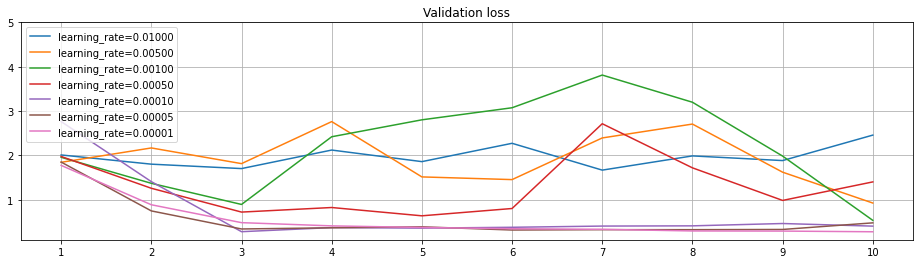

In [29]:
plt.figure(figsize=(16, 4))
for lr in l_rates:
    logs = history[lr].history
    epochs = history[lr].epoch
    plt.plot(np.array(epochs)+1, logs["val_loss"], label="learning_rate=%.5f" %lr)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation loss")
    plt.ylim([0.1, 5])

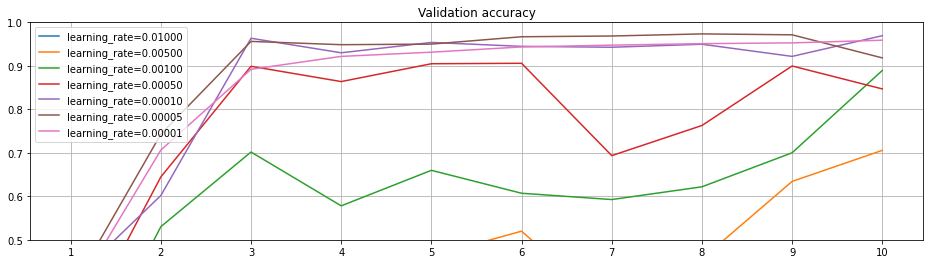

In [33]:
plt.figure(figsize=(16, 4))
for lr in l_rates:
    logs = history[lr].history
    epochs = history[lr].epoch
    plt.plot(np.array(epochs)+1, logs["val_accuracy"], label="learning_rate=%.5f" %lr)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation accuracy")
    plt.ylim([0.5,1])

In [6]:
%%capture outputs_dr
best_lr = 0.0001

droprates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

history_dr = dict()

for dr in droprates:
    detection_model = get_model(img_size, learning_rate=best_lr, droprate=dr)

    history_dr[dr] = detection_model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

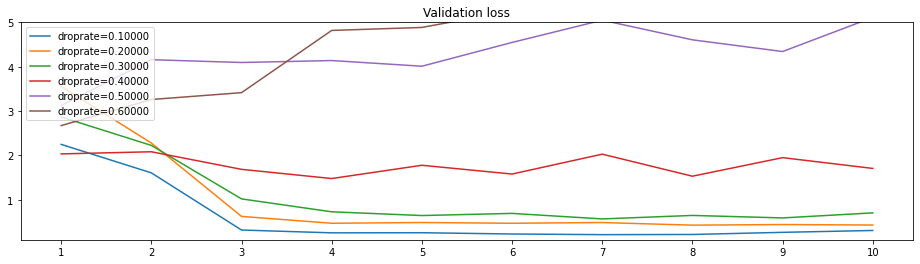

In [7]:
plt.figure(figsize=(16, 4))
for dr in droprates:
    logs = history_dr[dr].history
    epochs = history_dr[dr].epoch
    plt.plot(np.array(epochs)+1, logs["val_loss"], label="droprate=%.5f" %dr)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation loss")
    plt.ylim([0.1, 5])

<Figure size 1152x288 with 0 Axes>

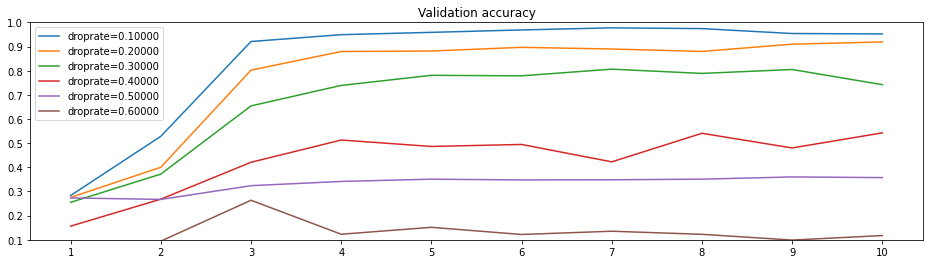

In [8]:
plt.figure(figsize=(16, 4))
plt.figure(figsize=(16, 4))
for dr in droprates:
    logs = history_dr[dr].history
    epochs = history_dr[dr].epoch
    plt.plot(np.array(epochs)+1, logs["val_accuracy"], label="droprate=%.5f" %dr)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation accuracy")
    plt.ylim([0.1, 1])

In [9]:
%%capture output_ep

best_lr = 0.0001
best_dr = 0.2

n_epochs = [5, 10, 15, 20, 25]

history_ep = dict()

for n in n_epochs:
    detection_model = get_model(img_size, learning_rate=best_lr, droprate=best_dr)

    history_ep[n] = detection_model.fit(train_dataset, epochs=n, validation_data=valid_dataset)

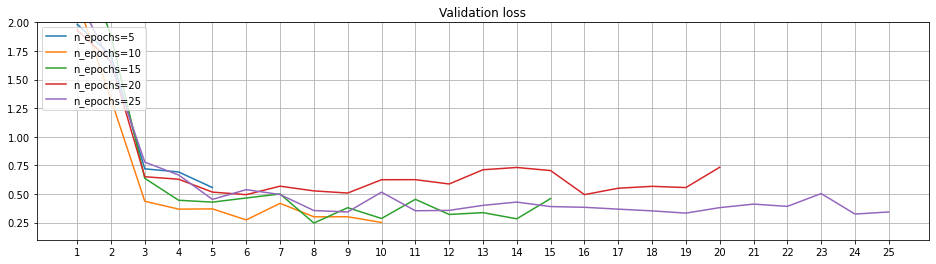

In [10]:
plt.figure(figsize=(16, 4))
for n in n_epochs:
    logs = history_ep[n].history
    epochs = history_ep[n].epoch
    plt.plot(np.array(epochs)+1, logs["val_loss"], label="n_epochs=%.f" %n)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation loss")
    plt.ylim([0.1, 2])

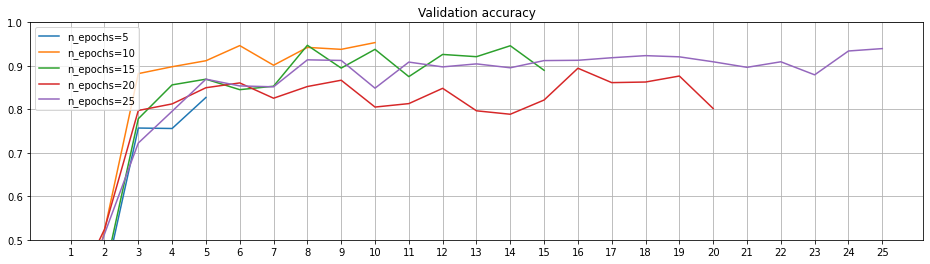

In [15]:
plt.figure(figsize=(16, 4))
for n in n_epochs:
    logs = history_ep[n].history
    epochs = history_ep[n].epoch
    plt.plot(np.array(epochs)+1, logs["val_accuracy"], label="n_epochs=%.f" %n)
    plt.grid()
    plt.xticks(np.array(epochs)+1)
    plt.legend(loc='upper left')
    plt.title("Validation accuracy")
    plt.ylim([0.5, 1])

In [5]:
best_lr = 0.0001
best_dr = 0.3
selected_n_epochs = 15

detection_model = get_model(img_size, learning_rate=best_lr, droprate=best_dr)

checkpoint = keras.callbacks.ModelCheckpoint("/kaggle/working/dice-detection-model-dr03-{val_accuracy:.3f}.h5",
                                            save_best_only=True, 
                                            monitor="val_accuracy",
                                            mode="max",
)

history_fin = detection_model.fit(train_dataset,
                                  epochs=selected_n_epochs,
                                  validation_data=valid_dataset,
                                 callbacks=[checkpoint])

236/236 [==============================] - 118s 471ms/step - loss: 0.8984 - accuracy: 0.6694 - val_loss: 2.2181 - val_accuracy: 0.2365
Epoch 2/15
236/236 [==============================] - 111s 469ms/step - loss: 0.3609 - accuracy: 0.8846 - val_loss: 2.3028 - val_accuracy: 0.3675
Epoch 3/15
236/236 [==============================] - 111s 472ms/step - loss: 0.2309 - accuracy: 0.9283 - val_loss: 1.0615 - val_accuracy: 0.6350
Epoch 4/15
236/236 [==============================] - 110s 467ms/step - loss: 0.1592 - accuracy: 0.9524 - val_loss: 0.8809 - val_accuracy: 0.7222
Epoch 5/15
236/236 [==============================] - 110s 468ms/step - loss: 0.1233 - accuracy: 0.9626 - val_loss: 0.9409 - val_accuracy: 0.7308
Epoch 6/15
236/236 [==============================] - 110s 467ms/step - loss: 0.0948 - accuracy: 0.9724 - val_loss: 0.8645 - val_accuracy: 0.7484
Epoch 7/15
236/236 [==============================] - 110s 467ms/step - loss: 0.0838 - accuracy: 0.9742 - val_loss: 0.9778 - val_accura